# Capital One - Company Reviews

## Web Scraping
Scraping company reviews - The only way to scrape Glassdoor data is to write a program that mimics a human user. Selenium is a library that lets you code a python script that would act just like a human user. Using Selenium, I was able to scrape the top 1000 reviews from Glassdoor about Captial One. In this notebook, I explore the data, and then perform topic modeling using LDA.


In [1]:
import re,string
import json
import nltk

from pprint import pprint
import pandas as pd
import os
import matplotlib
import functools
from functools import reduce

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as pyplt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import multiprocessing
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.collections import Counter
from nltk.tokenize import TreebankWordTokenizer
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
import sklearn.linear_model 

from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

RANDOM = 36 # To be reproducible

# set working file
os.chdir('/Users/rachelmartonik/MSDS_453_NLP/glassdoor-review-scraper-master')

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#### Read in data ####
data = pd.read_csv("cap_one_reviews.csv") 
data.head()

,date,employee_title,location,employee_status,review_title,years_at_company,helpful,pros,cons,advice_to_mgmt,rating_overall,rating_balance,rating_culture,rating_career,rating_comp,rating_mgmt
0,Mon Jan 13 2020 08:12:47 GMT-0500 (Eastern Sta...,Technical Recruiter,"McLean, VA",Current Employee,Love it!,I have been working at Capital One full-time f...,0,Great place to work with lots of advancement o...,It would be great if they had better coffee av...,NaN,5.0,5.0,5.0,5.0,5.0,5.0
1,Wed Feb 26 2020 18:21:23 GMT-0500 (Eastern Sta...,Branch Manager,NaN,Former Employee,Great Company,I worked at Capital One full-time,0,"Work-life Bslance, Opportunities, and environment",Nothing that I can think of,NaN,5.0,4.0,5.0,3.0,3.0,4.0
2,Wed Feb 26 2020 16:49:23 GMT-0500 (Eastern Sta...,Project Manager,"McLean, VA",Former Employee,"Overall a great company, just depends on what ...",I worked at Capital One full-time for more tha...,0,"Great health benefits, HQ campus is amazing",Not as easy to switch role as an internal asso...,NaN,4.0,3.0,4.0,2.0,4.0,2.0
3,Wed Feb 26 2020 18:05:36 GMT-0500 (Eastern Sta...,Software Engineer,"Deptford Township, NJ",Former Employee,"Good Benefits, Decent Managers",I worked at Capital One full-time for more tha...,0,"Good Benefits, Decent Managers, Great Cafeteria",Remote work option non -existent,NaN,4.0,4.0,5.0,4.0,4.0,4.0
4,Tue Feb 25 2020 14:46:24 GMT-0500 (Eastern Sta...,Treasury Management Sales Officer,"New York, NY",Current Employee,Great Company - Focus on people management &am...,I have been working at Capital One full-time f...,0,Managers not solely judged by personal accompl...,Sometimes too analysis/consensus driven - can ...,NaN,5.0,5.0,5.0,5.0,5.0,3.0


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              1000 non-null   object 
 1   employee_title    797 non-null    object 
 2   location          595 non-null    object 
 3   employee_status   1000 non-null   object 
 4   review_title      1000 non-null   object 
 5   years_at_company  1000 non-null   object 
 6   helpful           1000 non-null   int64  
 7   pros              1000 non-null   object 
 8   cons              1000 non-null   object 
 9   advice_to_mgmt    0 non-null      float64
 10  rating_overall    1000 non-null   float64
 11  rating_balance    850 non-null    float64
 12  rating_culture    849 non-null    float64
 13  rating_career     846 non-null    float64
 14  rating_comp       840 non-null    float64
 15  rating_mgmt       828 non-null    float64
dtypes: float64(7), int64(1), object(8)
memory u

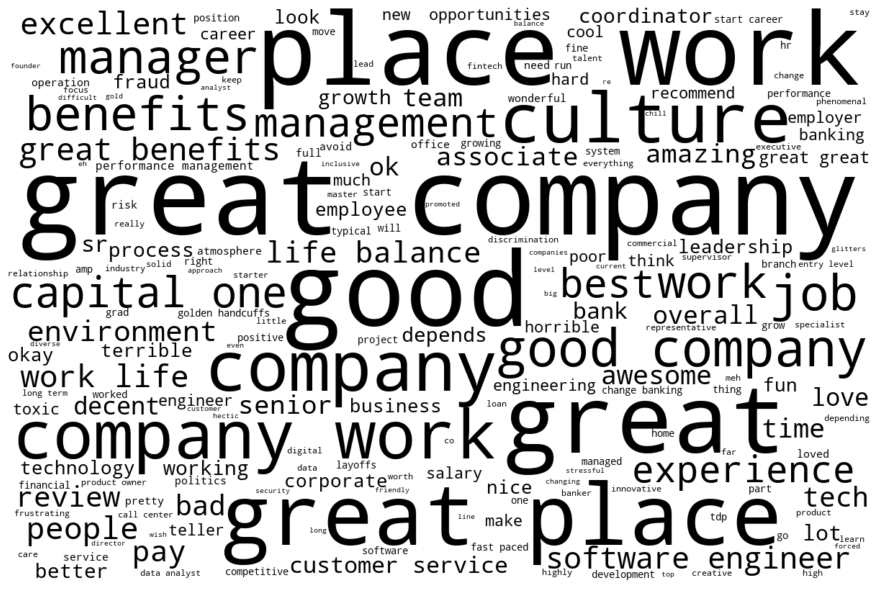

In [4]:
#### Word cloud of job titles ####
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
comment_words = ' '
stopwords = set(STOPWORDS) 
 
# iterate through the csv file 
for val in data.review_title:      
   # typecaste each val to string 
   val = str(val) 
   # split the value 
   tokens = val.split()     
   # Converts each token into lowercase 
   for i in range(len(tokens)): 
       tokens[i] = tokens[i].lower() 
         
   for words in tokens: 
       comment_words = comment_words + words + ' '
# words should all be same color and horizonal 
wordcloud = WordCloud(width = 1200, height = 800, 
               background_color ='white', 
               stopwords = stopwords,prefer_horizontal=1, color_func=lambda *args, **kwargs: "black",
               min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('review title word cloud.png')
plt.show() 


# EDA of data set and reviews

In [5]:
# To review longest and shortest reviews
# Longest review
def longeststring(lst):
  longest = ""
  for x in lst:
    if isinstance(x, str) and len(x) > len(longest):
      longest = x
  return longest

# Shortest review
def shorteststring(lst):
  shortest = ""
  for x in lst:
    if isinstance(x, str) and len(x) < len(shortest):
      shortest = x
  return shortest

def get_words(doc): 
    tokens=doc.split()
    return tokens

pro_long = longeststring(data['pros'])
pro_long_df = data.loc[data['pros'] == pro_long]
pro_short = shorteststring(data['pros'])
con_long = longeststring(data['cons'])
con_long_df = data.loc[data['cons'] == con_long]
con_short = shorteststring(data['cons'])

In [6]:
# Take a look at the pros
print(data['pros'][0:10])

0    Great place to work with lots of advancement o...
1    Work-life Bslance, Opportunities, and environment
2          Great health benefits, HQ campus is amazing
3      Good Benefits, Decent Managers, Great Cafeteria
4    Managers not solely judged by personal accompl...
5    Dynamic forward thinking company, Broad range ...
6    - Excellent salary and benefits. - Work/life b...
7    Great coworkers Smart leaders Opportunities fo...
8            Flexible work arrangements, great culture
9             Great Benefits, Management. Flexible PTO
Name: pros, dtype: object


In [7]:
print('The longest positive review is: ' + str(len(get_words(pro_long))) + ' words\r')
print('Submitted on: ' + str(pro_long_df['date']))
print(pro_long_df['employee_title'])
print(pro_long)

The longest positive review is: 423 words
Submitted on: 558    Tue Apr 30 2019 17:14:19 GMT-0400 (Eastern Day...
Name: date, dtype: object
558     Senior Business Analyst
Name: employee_title, dtype: object
Disclaimer: My feedback is specific to the analyst development rotational program and general corporate strategy functions - cannot comment on the experiences of cross-functional staff (HR, IT, etc) and field employees (branch, call center, etc). It's a truly impressive company that built itself out of nothing in the early 90's and is now a top-10 bank and respected brand in the corporate world. That stems from the leadership of the founder, Rich Fairbank, an ex-consultant who, nearly 30 years later, remains closely involved in the company's direction. I think there are three principles that characterize the company's core values, and each one accounts for both pros (outlined below) and cons (next section): The first is its Information-based strategy - Capital One takes a fiercely-e

In [8]:
print('The shortes positive review is: ' + str(len(get_words(pro_short))) + ' words\r')
print(pro_short) # so we have some missing data here

The shortes positive review is: 0 words



In [9]:
# Take a look at the cons
print(data['cons'][0:10])

0    It would be great if they had better coffee av...
1                          Nothing that I can think of
2    Not as easy to switch role as an internal asso...
3                     Remote work option non -existent
4    Sometimes too analysis/consensus driven - can ...
5    Constant reorganizations and layoffs, overly o...
6    - Company is big with lots of departments, so ...
7    Frequent reorganization’s in some parts of the...
8                             Fast pace, high workload
9                             None to be said for Cons
Name: cons, dtype: object


In [10]:
print('The longest positive review is: ' + str(len(get_words(con_long))) + ' words\r')
print('Submitted on: ' + str(con_long_df['date']))
print(con_long_df['employee_title'])
print(con_long) #yikes

The longest positive review is: 685 words
Submitted on: 101    Fri Feb 07 2020 20:33:11 GMT-0500 (Eastern Sta...
Name: date, dtype: object
101     Principal Associate
Name: employee_title, dtype: object
Unfortunately, all of the above is meaningless because Capital One's performance management system is an unmitigated disaster. I could write a book about how horrible it is, but I'll try and condense everything below. (I WISH I KNEW THIS BEFORE I CAME TO CAP ONE. PLEASE TAKE THIS SERIOUSLY) 1) At capital one there's an assumption that the level you came in at is the absolute highest that you could have, and once you start, nothing you did before capital one matters. 2) You will stay at your current level unless you kiss up to your manager because vertical movement at Cap One is seriously messed up. The ONLY WAY to get a role at a higher level is to get promoted by your current manager, which is very hard, or to find a role at the next level and humbly ask the posting manager if he/she w

In [11]:
print('The shortes positive review is: ' + str(len(get_words(con_short))) + ' words\r')
print(con_short)
# so we have some missing data here

The shortes positive review is: 0 words



In [12]:
# Employee Title
value_counts = data['employee_title'].value_counts(dropna=True, sort=True)
mpn = value_counts.rename_axis('employee_title').reset_index(name='counts')
(mpn['counts']).describe()

# 341 different job titles in total

count    341.000000
mean       2.337243
std        4.019883
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       42.000000
Name: counts, dtype: float64

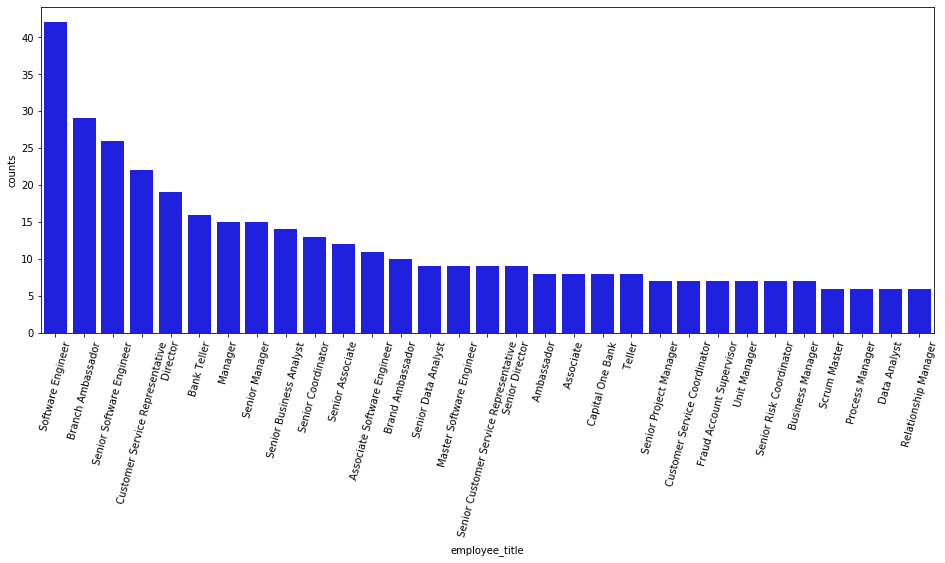

In [13]:
# Look at the job titles with a frequency greater than 5
mpn[["counts"]] = mpn[["counts"]].apply(pd.to_numeric)
new = mpn[mpn['counts'] > 5]
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="employee_title", y="counts", data=new, color="b")
plt.setp(ax.get_xticklabels(), rotation=75);

In [14]:
# Look at all employee titles
data['employee_title'].value_counts(dropna=True, sort=True)

 Software Engineer                  42
 Branch Ambassador                  29
 Senior Software Engineer           26
 Customer Service Representative    22
 Director                           19
                                    ..
 Credit Specialist                   1
 Senior Operations Manager           1
 Senior Learning Specialist          1
 Agile Delivery Lead                 1
 Senior AML Investigator I           1
Name: employee_title, Length: 341, dtype: int64

In [15]:
# Location of reviewer
# Would be intersting to pull out reviews from McLean, VA only as that is where I would want to work
data['location'].value_counts(dropna=True, sort=True)

Richmond, VA             112
McLean, VA                96
Plano, TX                 86
New York, NY              39
Tampa, FL                 29
                        ... 
Deptford Township, NJ      1
Canada, KS                 1
Woodbridge, NJ             1
Schaumburg, IL             1
Tulsa, OK                  1
Name: location, Length: 74, dtype: int64

In [16]:
# Years at company
print(data['years_at_company'])

0      I have been working at Capital One full-time f...
1                      I worked at Capital One full-time
2      I worked at Capital One full-time for more tha...
3      I worked at Capital One full-time for more tha...
4      I have been working at Capital One full-time f...
                             ...                        
995    I have been working at Capital One for more th...
996         I have been working at Capital One full-time
997    I have been working at Capital One for less th...
998                   I have been working at Capital One
999    I have been working at Capital One full-time f...
Name: years_at_company, Length: 1000, dtype: object


In [17]:
# Years at company - frequency
value_counts = data['years_at_company'].value_counts(dropna=True, sort=True)
mpn = value_counts.rename_axis('years_at_company').reset_index(name='counts')
mpn
# Would be nice to categorize this into years
# Also perhaps pull out part time employees?

,years_at_company,counts
0,I have been working at Capital One full-time f...,136
1,I have been working at Capital One full-time,114
2,I have been working at Capital One full-time f...,113
3,I worked at Capital One full-time for more tha...,88
4,I have been working at Capital One full-time f...,71
5,I have been working at Capital One full-time f...,69
6,I worked at Capital One full-time for more tha...,61
7,I worked at Capital One full-time,60
8,I worked at Capital One full-time for more tha...,57
9,I worked at Capital One full-time for less tha...,43


In [18]:
(data['rating_overall']).describe() # Mean rating of 3.8

count    1000.000000
mean        3.806000
std         1.194902
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating_overall, dtype: float64

# Cleaning the reviews

In [19]:
pro_text_body=[]
for i in range(0,len(data)):
    temp_text=data['pros'].iloc[i]
    pro_text_body.append(temp_text)
    
con_text_body=[]
for i in range(0,len(data)):
    temp_text=data['cons'].iloc[i]
    con_text_body.append(temp_text)

In [84]:
# Settings for vectorization
STEMMING = False  # judgment call, parsed documents more readable if False
MAX_NGRAM_LENGTH = 2  # Experiment with n-gram length
VECTOR_LENGTH = 2000  # set vector length for TF-IDF and Doc2Vec

In [85]:
# Function to clean documents
from nltk.corpus import stopwords 
def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    # # filter out short words
    tokens = [word for word in tokens if len(tokens) > 3]
    # #lowercase all words
    tokens = [word.lower() for word in tokens]  
    stop_words = list(stopwords.words('english'))
    stop_words.append('capital one')
    stop_words.append('one')
    tokens = [w for w in tokens if not w in stop_words]         
    re_same_words = re.compile(r'lot')
    tokens = [re_same_words.sub('lots', w) for w in tokens]
    re_same_words = re.compile(r'lotss')
    tokens = [re_same_words.sub('lots', w) for w in tokens]
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens

In [86]:
# Create empty list to store processed documents
pro_processed_text=[]
con_processed_text=[]

# Process documents - pros
for i in pro_text_body:
    text=clean_doc(i)
    pro_processed_text.append(text)
pro_processed_text[0]

# Process documents - cons
for i in con_text_body:
    text=clean_doc(i)
    con_processed_text.append(text)
con_processed_text[0]

['would', 'great', 'better', 'coffee', 'available']

In [87]:
len(con_processed_text)

1000

In [88]:
pro_final_processed_text=[]

for i in pro_processed_text:
    temp_DSI=" ".join(str(item) for item in i )
    pro_final_processed_text.append(temp_DSI)
    
print('\nExample of what one parsed document looks like:\n')
print(pro_final_processed_text[4])


Example of what one parsed document looks like:

managers solely judged personal accomplishments rather effectively manage team result creates collaborative culture supportive managers huge focus person development flexible work locationhours make sure get work done


In [89]:
# Combine for final processed text list - cons
con_final_processed_text=[]

for i in con_processed_text:
    temp_DSI=" ".join(str(item) for item in i )
    con_final_processed_text.append(temp_DSI)
    
print('\nExample of what one parsed document looks like:\n')
print(con_final_processed_text[4])


Example of what one parsed document looks like:

sometimes analysisconsensus driven delay decision making process formal training relatively lacking learn team vs job


In [90]:
# combine the reviews and label by pro/con
combined_final_processed_text = pro_final_processed_text.copy()
combined_final_processed_text.extend(con_final_processed_text) 
print(len(combined_final_processed_text))
print(len(pro_final_processed_text))
print(len(con_final_processed_text))

2000
1000
1000


In [91]:
# Create pro and con labels to use later
pro_con_labels=[]
pro_list = ['pro' for i in range(1000)]
con_list = ['con' for i in range(1000)]
pro_con_labels = pro_list
pro_con_labels.extend(con_list) 

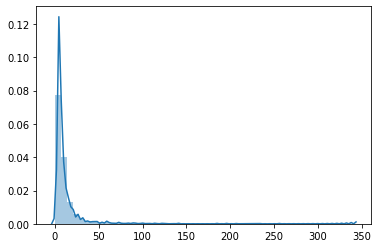

In [92]:
# Histogram of word counts per review
from nltk.tokenize import word_tokenize
reviews_tokenized = [word_tokenize(combined_final_processed_text[i]) for i in range(0,len(combined_final_processed_text))]

# Create a list for clean snippets.
HFU_clean = [None] * len(reviews_tokenized)
# Create a list of word counts for each clean snippet.
word_counts_per_snippet = [None] * len(reviews_tokenized)

# Process words in all snippets.
for i in range(len(reviews_tokenized)):
    HFU_clean[i] = [snippet.lower() for snippet in reviews_tokenized[i]]
    word_counts_per_snippet[i] = len(HFU_clean[i])

sns.distplot(word_counts_per_snippet)

In [93]:
word_counts_df = pd.DataFrame(word_counts_per_snippet) 

#word_counts_df.0.value_counts()
word_counts_df.describe()

,0
count,2000.000000
mean,11.959000
std,20.284626
min,0.000000
25%,4.000000
50%,6.000000
75%,11.250000
max,340.000000


In [94]:
word_counts_df.sort_values(axis=1, by=[1])
# 6 reviews with 0 words
# Drop with less than 4 words?

,0
0,6
1,4
2,6
3,6
4,27
...,...
1995,6
1996,18
1997,4
1998,3


# TF-IDF Vectorization

In [95]:
### Sklearn TFIDF 
VECTOR_LENGTH = 450
MAX_NGRAM_LENGTH = 2

# Note the ngram_range will allow you to include multiple-word tokens within the TFIDF matrix
Tfidf=TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
TFIDF_matrix=Tfidf.fit_transform(combined_final_processed_text)     

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns = Tfidf.get_feature_names())

In [96]:
import numpy as np
pd.set_option('display.max_rows', 500) # increase notebook output
# Explore TFIDF Values - set average value and identify outliers
average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])

average_TFIDF_DF = pd.DataFrame(average_TFIDF,index = [0]).transpose()

average_TFIDF_DF.columns=['TFIDF']

# sort by highest average TF-IDF score
average_TFIDF_DF.sort_values(by=['TFIDF'], ascending=False)

,TFIDF
great,0.057699
work,0.051191
benefits,0.048511
good,0.037062
company,0.034860
management,0.032193
people,0.028846
pay,0.028236
lots,0.026140
culture,0.026016


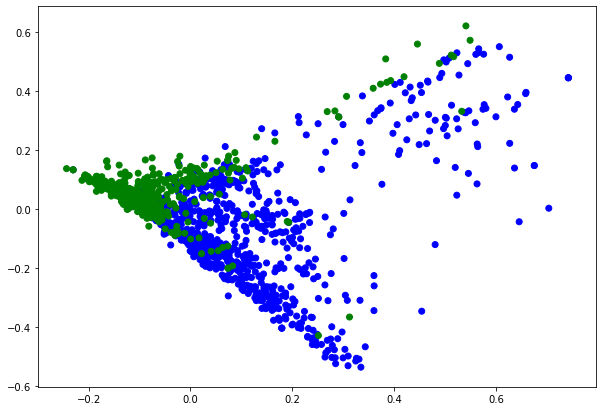

In [97]:
# PCA of combined reviews with top 500 wors from TF-IDF
# Colored by pro or con
# Label to color dict (manual)
label_color_dict = {'pro':'blue','con':'green'}

# Color vector creation
cvec = [label_color_dict[label] for label in pro_con_labels]

pca = PCA(n_components=2, random_state=RANDOM)
result = pca.fit_transform(matrix)
plt.figure(figsize = (10, 7))
plt.scatter(result[:, 0], result[:, 1], c=cvec)
plt.savefig('pro_con_PCA.png')
plt.show() 

In [98]:
# Create Vocab with final processed text
tokenizer = TreebankWordTokenizer()
tokenized_sents = [tokenizer.tokenize(i) for i in combined_final_processed_text]
tokenized_sents = reduce(lambda x, y: x + y, tokenized_sents, [])

vocab = Counter(tokenized_sents)
print(len(vocab))
vocab.most_common()

4178


[('great', 537),
 ('work', 536),
 ('benefits', 413),
 ('company', 330),
 ('good', 309),
 ('management', 303),
 ('people', 295),
 ('pay', 204),
 ('lots', 203),
 ('culture', 194),
 ('balance', 190),
 ('get', 175),
 ('environment', 146),
 ('life', 129),
 ('performance', 127),
 ('time', 125),
 ('capital', 122),
 ('team', 121),
 ('managers', 116),
 ('opportunities', 115),
 ('employees', 113),
 ('like', 107),
 ('job', 105),
 ('manager', 89),
 ('many', 87),
 ('growth', 86),
 ('tech', 86),
 ('much', 86),
 ('really', 85),
 ('working', 80),
 ('place', 77),
 ('career', 76),
 ('worklife', 75),
 ('new', 74),
 ('hours', 73),
 ('hard', 72),
 ('nice', 66),
 ('dont', 65),
 ('leadership', 65),
 ('well', 63),
 ('even', 63),
 ('flexible', 62),
 ('training', 62),
 ('technology', 61),
 ('salary', 60),
 ('competitive', 59),
 ('year', 59),
 ('development', 57),
 ('always', 57),
 ('process', 57),
 ('business', 56),
 ('high', 55),
 ('amazing', 52),
 ('move', 52),
 ('care', 52),
 ('office', 50),
 ('opportunity',

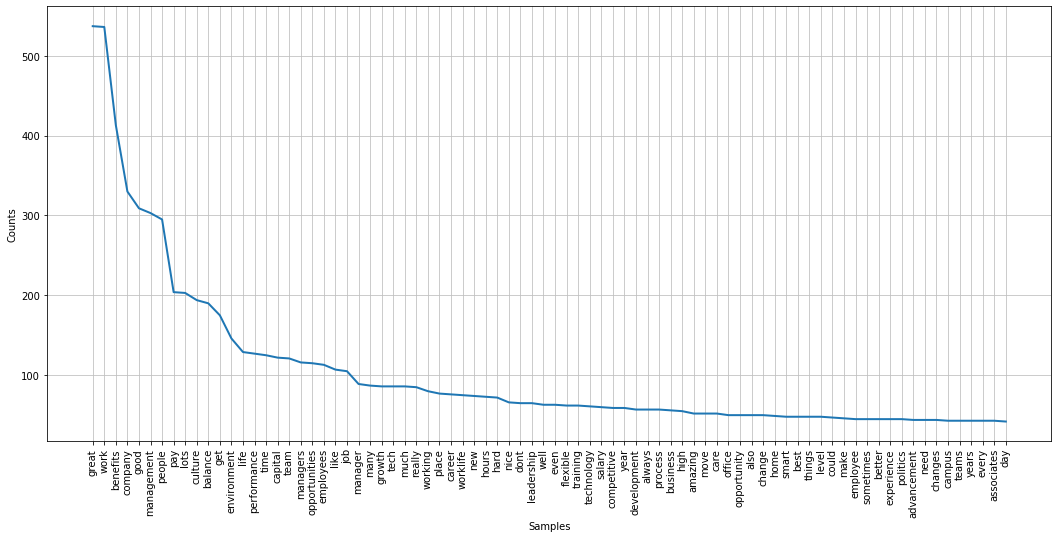

In [99]:
# Histogram of vocabulary and save file for future use
# Save as a FreqDist object native to nltk.
corpus_freq_dist = nltk.FreqDist(vocab)
corpus_freq_dist
# Plot distribution for the entire corpus.
plt.figure(figsize = (18, 8)) 
a = corpus_freq_dist.plot(80)

# Classification

Can we classify the positive vs negative reviews? PCA shows a clear separation, although overlap does exist.


In [100]:
# create dataframe of reviews and labels
review_df = pd.DataFrame(combined_final_processed_text) 
review_df = review_df.rename({0:'review_text'}, axis='columns')
labels_df = pd.DataFrame(pro_con_labels)
labels_df = labels_df.rename({0:'target'}, axis='columns')
reviews = pd.concat([labels_df, review_df], axis=1, sort=False)
reviews

,target,review_text
0,pro,great place work lots advancement opportunities
1,pro,worklife bslance opportunities environment
2,pro,great health benefits hq campus amazing
3,pro,good benefits decent managers great cafeteria
4,pro,managers solely judged personal accomplishment...
...,...,...
1995,con,performance management pits colleagues good re...
1996,con,work slowmoving bureaucratic since bank backen...
1997,con,slow change often changes
1998,con,cons company great


In [101]:
# create train and test data set
from sklearn.utils import shuffle
reviews_shuffled = shuffle(reviews)
reviews_shuffled # shuffle the data set

# Prepare Train Data
from sklearn.model_selection import train_test_split
#Split data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(reviews_shuffled.drop('target', axis = 1), 
                                                    reviews_shuffled['target'])
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1500
500
1500
500


In [102]:
##### Prepare Train Data ######
train_tokens = []  # list of token lists for gensim Doc2Vec
train_text = [] # list of document strings for sklearn TF-IDF

#create empty list to store text documents
data = X_train
text_body=[]
for i in range(0,len(data)):
    temp_text=data['review_text'].iloc[i]
    text_body.append(temp_text)
    
processed_text=[]
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)
    
final_processed_text=[]
for i in processed_text:
    temp_DSI=" ".join(str(item) for item in i )
    final_processed_text.append(temp_DSI)
    
train_text = final_processed_text   
train_tokens = processed_text
print(len(train_text))
print(len(train_tokens))

1500
1500


In [103]:
# Prepare Train Data
test_tokens = []  # list of token lists for gensim Doc2Vec
test_text = [] # list of document strings for sklearn TF-IDF

#create empty list to store text documents
data = X_test
text_body=[]
for i in range(0,len(data)):
    temp_text=data['review_text'].iloc[i]
    text_body.append(temp_text)
    
processed_text=[]
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)
    
final_processed_text=[]
for i in processed_text:
    temp_DSI=" ".join(str(item) for item in i )
    final_processed_text.append(temp_DSI)
    
test_text = final_processed_text   
test_tokens = processed_text
print(len(test_text))
print(len(test_tokens))

500
500


In [104]:
VECTOR_LENGTH = 1000
# Apply the same vectorizer to the train data
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = VECTOR_LENGTH)
tfidf_vectors = tfidf_vectorizer.fit_transform(train_text)
print('\nTFIDF vectorization. . .')
print('\nTraining tfidf_vectors_training.shape:', tfidf_vectors.shape)

# Apply the same vectorizer to the test data
# Use .transform because we fit vectorizer to train data
tfidf_vectors_test = tfidf_vectorizer.transform(test_text)
print('\nTest tfidf_vectors_test.shape:', tfidf_vectors_test.shape)
tfidf_clf = RandomForestClassifier(n_estimators =100, max_depth = 40, random_state = RANDOM)
#tinker with hyperparameters - do crossvalidation
# Plot ROC curve


TFIDF vectorization. . .

Training tfidf_vectors_training.shape: (1500, 1000)

Test tfidf_vectors_test.shape: (500, 1000)


In [105]:
tfidf_clf.fit(tfidf_vectors, y_train)
tfidf_pred = tfidf_clf.predict(tfidf_vectors_test)  

# evaluate on test set
print('\nTF-IDF/Random forest F1 classification performance in test set:',
round(metrics.f1_score(y_test, tfidf_pred, average='macro'), 3))
print(accuracy_score(y_test, tfidf_pred))

# adding "work" and "place" increased accuracy in test set by 2%


TF-IDF/Random forest F1 classification performance in test set: 0.84
0.84


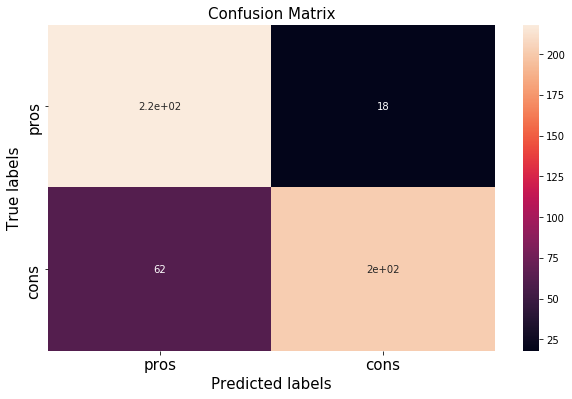

In [106]:
# Confusion Matrix for prediction results - not bad!
cm = confusion_matrix(y_test, tfidf_pred)

plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(cm, annot=True,ax = ax); #annot=True to annotate cells
ax.set_xlabel('Predicted labels',  fontsize=15);
ax.set_ylabel('True labels',  fontsize=15); 
ax.set_title('Confusion Matrix',  fontsize=15); 
ax.xaxis.set_ticklabels(['pros', 'cons'],  fontsize=15); 
ax.yaxis.set_ticklabels(['pros', 'cons'],  fontsize=15);


# Topic Modeling

The following are key factors to obtaining good segregation topics:

The quality of text processing.

The variety of topics the text talks about.

The choice of topic modeling algorithm.

The number of topics fed to the algorithm.

The algorithms tuning parameters.

In [161]:
# Packages for getting data ready for and building a LDA model
import gensim
from gensim import corpora, models
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel

# Change this for whatever starting text you are using
text_to_use = pro_final_processed_text

In [162]:
# tokenize sentences
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(text_to_use))

print(data_words[:1])

[['great', 'place', 'work', 'lots', 'advancement', 'opportunities']]


Text(0, 0.5, 'Frequency')

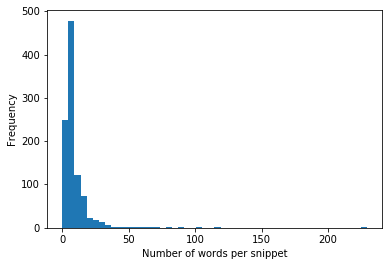

In [163]:
# Remove short reviews
# Create a list for clean snippets.
words_clean = [None] * len(data_words)
# Create a list of word counts for each clean snippet.
word_counts_per_snippet = [None] * len(data_words)

# Process words in all snippets.
for i in range(len(data_words)):
    words_clean[i] = [snippet.lower() for snippet in data_words[i]]
    word_counts_per_snippet[i] = len(words_clean[i])
    
    # Plot a histogram for word counts per snippet, set bins to num of unique values in the list.
plt.hist(word_counts_per_snippet, bins = len(set(word_counts_per_snippet))) 
plt.xlabel('Number of words per snippet')
plt.ylabel('Frequency')

In [164]:
# Convert word counts list and snippets list to numpy arrays.
word_counts_array = np.array(word_counts_per_snippet) 
clean_array = np.array(words_clean) 
print(len(clean_array))

1000


In [165]:
# Find indices of all snippets where there are greater than or equal to 4 words.
valid_snippets = np.where(word_counts_array >= 5)[0] 
print(len(valid_snippets))

752


In [166]:
# Subset the clean_array to keep only those where there are at least 4 words.
clean_array = clean_array[valid_snippets] 
print(len(clean_array))
# Convert the array back to a list.
clean_array = clean_array.tolist() 


752


In [167]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(clean_array, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[clean_array], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[clean_array[0]]])

['great', 'place', 'work', 'lots', 'advancement', 'opportunities']


In [168]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [169]:
# # Form Bigrams
# data_words_bigrams = make_bigrams(clean_array)

# # Do lemmatization keeping only noun, adj, vb, adv
# # data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_words_bigrams[:1])

In [170]:
# # Create Dictionary
# id2word = corpora.Dictionary(data_words_bigrams)

# # Create Corpus
# texts = data_words_bigrams

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

# # View
# print(corpus[:1])

# # Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [171]:
# LEMMNITIZE
# Form Bigrams
data_words_bigrams = make_bigrams(clean_array)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[['great', 'place', 'work', 'lot', 'advancement', 'opportunity']]
[[(0, 1), (1, 1), (4, 1), (5, 1), (546, 1)]]


[[('advancement', 1), ('great', 1), ('place', 1), ('work', 1), ('lots', 1)]]

In [172]:
nlp = spacy.load("en_core_web_sm")

In [173]:
len(corpus) # removed 91 reviews because after cleaning they were 4 words or less

752

# Building the Topic Model
In addition to the corpus and dictionary, you need to provide the number of topics as well.

__alpha__ and __beta__ are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior. Alpha parameter is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document. Beta parameter is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

__chunksize__ is the number of documents to be used in each training chunk. 

__update_every__ determines how often the model parameters should be updated and passes is the total number of training passes.

The  LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

The relationship between chunksize, passes, and update_every is the following:

__passes:__ Number of passes through the entire corpus

__chunksize:__ Number of documents to load into memory at a time and process E step of EM.

__update_every:__ number of chunks to process prior to moving onto the M step of EM.


--In general a chunksize of 100k and update_every set to 1 is equivalent to a chunksize of 50k and update_every set to 2. The primary difference is that you will save some memory using the smaller chunksize, but you will be doing multiple loading/processing steps prior to moving onto the maximization step. Passes are not related to chunksize or update_every. Passes is the number of times you want to go through the entire corpus. Below are a few examples of different combinations of the 3 parameters and the number of online training updates which will occur while training LDA.

    chunksize = 100k, update_every=1, corpus = 1M docs, passes =1 : 10 updates total
    chunksize = 50k ,  update_every=2, corpus = 1M docs, passes =1 : 10 updates total
    chunksize = 100k, update_every=1, corpus = 1M docs, passes =2 : 20 updates total
    chunksize = 100k, update_every=1, corpus = 1M docs, passes =4 : 40 updates total

In [174]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=13, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=10,
                                           alpha=.6,
                                           per_word_topics=True)

In [175]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.123*"lots" + 0.062*"get" + 0.059*"technology" + 0.051*"new" + 0.049*"fun" '
  '+ 0.039*"tech" + 0.035*"move" + 0.025*"high" + 0.022*"talent" + '
  '0.021*"overall"'),
 (1,
  '0.053*"career" + 0.050*"development" + 0.048*"opportunity" + 0.048*"learn" '
  '+ 0.048*"management" + 0.045*"growth" + 0.037*"many" + 0.036*"leadership" + '
  '0.031*"amazing" + 0.027*"grow"'),
 (2,
  '0.443*"good" + 0.095*"pay" + 0.061*"people" + 0.038*"atmosphere" + '
  '0.026*"talented" + 0.023*"cutting_edge" + 0.022*"relaxed" + '
  '0.015*"exposure" + 0.012*"away" + 0.010*"okay"'),
 (3,
  '0.123*"worklife" + 0.063*"campus" + 0.051*"competitive" + 0.047*"friendly" '
  '+ 0.043*"amp" + 0.039*"compensation" + 0.038*"free" + 0.027*"food" + '
  '0.027*"diverse" + 0.026*"around"'),
 (4,
  '0.324*"culture" + 0.125*"place" + 0.053*"learning" + 0.032*"fast" + '
  '0.030*"different" + 0.025*"professional" + 0.018*"benefit" + '
  '0.016*"dynamic" + 0.012*"progressive" + 0.010*"lead"'),
 (5,
  '0.055*"working" 

In [176]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.770803376109117

Coherence Score:  0.45439915427009914


# Number of Topics

Compute the coherance score for a range of topics to see which one performs best

In [59]:
# Compute the coherance score for a range of topics to see which one performs best
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=10,
                                           alpha=.6,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary,
coherence='c_v') 
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [177]:
start = 2
limit = 40
step = 2

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=data_words_bigrams, limit=limit, start=start, step=step)

NameError: name 'compute_coherence_values' is not defined

In [178]:
# Plot graph of topic list
# Show graph
import matplotlib.pyplot as plt 
limit=limit; start=start; step=step;
plt.figure(figsize=(15, 10))
x = range(start, limit, step)
plt.plot(x, coherence_values) 
plt.xlabel("Num Topics") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best') 
plt.savefig('pro_coherence.png')
plt.show() 

#17 best number of negative topics

NameError: name 'coherence_values' is not defined

<Figure size 1080x720 with 0 Axes>

In [179]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: name 'coherence_values' is not defined

In [180]:
# Get the topics with the highest coherence score the coherence for each topic.
# Shows coherence score for each topic (ranked)
lda_model.top_topics(corpus=corpus, texts=data_words_bigrams, dictionary=id2word, coherence='c_v', topn=13, processes=-1)

[([(0.06521011, 'time'),
   (0.038836952, 'health'),
   (0.032052338, 'leave'),
   (0.029519107, 'pretty'),
   (0.027134802, 'vacation'),
   (0.024890399, 'care'),
   (0.020415243, 'easy'),
   (0.019825641, 'innovative'),
   (0.01961976, 'day'),
   (0.016168877, 'much'),
   (0.015715972, 'center'),
   (0.014839987, 'code'),
   (0.014835318, 'generous')],
  0.4943661611812634),
 ([(0.26316863, 'people'),
   (0.111546345, 'smart'),
   (0.06837145, 'flexibility'),
   (0.051985655, 'awesome'),
   (0.025747566, 'collaborative'),
   (0.025472777, 'diversity'),
   (0.025335519, 'manager'),
   (0.016930062, 'caring'),
   (0.015677487, 'supportive'),
   (0.012059343, 'mostly'),
   (0.0120584, 'else'),
   (0.011849784, 'stack'),
   (0.011500758, 'focused')],
  0.4852863423763945),
 ([(0.043985385, 'really'),
   (0.028655825, 'best'),
   (0.028562052, 'office'),
   (0.027506541, 'always'),
   (0.025282204, 'job'),
   (0.022757668, 'worked'),
   (0.02269868, 'capital'),
   (0.021843785, 'business'

# Topic Visualization

 - Topics in circles closer to each other are closer to each other in meaning
 - Topics farther away are more dissimilar in meaning
 - Circle size is related to the number of documents that contain the topic
      - Topics found in more documents are bigger circles
      - Topics found in fewer documents are smaller circles
      

 - Blue bars represent the overall term frequency in corpus
 - Red bars represent term frequency in selected topic
 - The slider at the top represents the value of lamda, a relevance metric
    - Default is 1 which means that the term's place in the relevance ranking below is solely based on its frequency within a selected topic
     - When 0, the ranking re-arranges itself to be based on the term's frequency within topic with respect to its freuqncy within corpus
     - When set to be between 0 and 1,the ranking will depend on both 

In [181]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.096765  0.188743  1       1        10.936148
10    -0.029986 -0.115520  2       1        9.728646 
5     -0.075884  0.120854  3       1        9.524856 
11     0.361492  0.059001  4       1        9.113614 
9     -0.108914 -0.031840  5       1        8.615049 
1     -0.081047  0.136284  6       1        8.314771 
0     -0.032429  0.038015  7       1        8.053617 
3      0.088258 -0.008184  8       1        7.253571 
7      0.030957 -0.137534  9       1        6.200345 
2     -0.061218 -0.239830  10      1        6.124729 
8      0.030876  0.018870  11      1        5.937932 
4      0.001974  0.012968  12      1        5.700078 
12    -0.027315 -0.041825  13      1        4.496640 , topic_info=                       Term        Freq       Total Category  logprob  loglift
1     great                  304.000000  304.000000  Default  30.0000  30.0000
11    good                   183.000000  183.000000  Default  29.0000  29.0000
5     work                   220.000000  220.000000  Default  28.0000  28.0000
16    culture                119.000000  119.000000  Default  27.0000  27.0000
62    people                 134.000000  134.000000  Default  26.0000  26.0000
41    balance                116.000000  116.000000  Default  25.0000  25.0000
37    environment            80.000000   80.000000   Default  24.0000  24.0000
36    company                115.000000  115.000000  Default  23.0000  23.0000
78    life                   75.000000   75.000000   Default  22.0000  22.0000
546   lots                   69.000000   69.000000   Default  21.0000  21.0000
49    worklife               59.000000   59.000000   Default  20.0000  20.0000
84    pay                    92.000000   92.000000   Default  19.0000  19.0000
4     place                  47.000000   47.000000   Default  18.0000  18.0000
55    smart                  45.000000   45.000000   Default  17.0000  17.0000
83    nice                   43.000000   43.000000   Default  16.0000  16.0000
20    flexible               43.000000   43.000000   Default  15.0000  15.0000
48    salary                 35.000000   35.000000   Default  14.0000  14.0000
82    training               37.000000   37.000000   Default  13.0000  13.0000
10    decent                 33.000000   33.000000   Default  12.0000  12.0000
182   time                   41.000000   41.000000   Default  11.0000  11.0000
59    pto                    29.000000   29.000000   Default  10.0000  10.0000
150   get                    42.000000   42.000000   Default  9.0000   9.0000 
7     campus                 30.000000   30.000000   Default  8.0000   8.0000 
69    flexibility            27.000000   27.000000   Default  7.0000   7.0000 
120   well                   33.000000   33.000000   Default  6.0000   6.0000 
106   working                34.000000   34.000000   Default  5.0000   5.0000 
34    team                   41.000000   41.000000   Default  4.0000   4.0000 
313   technology             36.000000   36.000000   Default  3.0000   3.0000 
177   new                    36.000000   36.000000   Default  2.0000   2.0000 
43    career                 32.000000   32.000000   Default  1.0000   1.0000 
254   really                 30.747471   31.571310   Topic1  -3.1239   2.1867 
117   best                   20.031521   20.855850   Topic1  -3.5524   2.1728 
189   office                 19.965969   20.794048   Topic1  -3.5557   2.1725 
164   always                 19.228127   20.050316   Topic1  -3.5933   2.1712 
482   job                    17.673229   18.495420   Topic1  -3.6777   2.1676 
1248  worked                 15.908483   16.731627   Topic1  -3.7829   2.1626 
111   business               15.269643   16.175386   Topic1  -3.8238   2.1555 
131   location               13.841805   14.664005   Topic1  -3.9220   2.1554 
228   also                   13.233748   14.056059   Topic1  -3.96

In [65]:
# Save the plot as a self­contained HTML file.
pyLDAvis.save_html(vis,"POS_LDAvis.html")

# Inspect the topics for the positive reviews

In [182]:
# Create dataframe that takes hishest rated topic for each document
doc_num = 4
# Extract the vector of tf_idf weights for the document.
doc_vec = corpus[doc_num] 
print(doc_vec)

doc_topics = lda_model.get_document_topics(doc_vec) 
print(doc_topics)

[(5, 1), (20, 1), (32, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (417, 1), (429, 1)]
[(0, 0.03374329), (1, 0.03371072), (2, 0.033710785), (3, 0.033718567), (4, 0.09057853), (5, 0.03822434), (6, 0.033929285), (7, 0.09128026), (8, 0.3747338), (9, 0.08449974), (10, 0.033710726), (11, 0.08444232), (12, 0.03371764)]


In [183]:
# Initialize maximum probability score.
max_prob = 0
# Initialize best topic.
best_topic = 0
# Loop over all topics for the document. 
for topic in doc_topics:
    if max_prob <= topic[1]: #if current topic's probability is as high as max 
        max_prob = topic[1] # make current topic's probability the new max 
        best_topic = topic[0] #<­ make current topic best
# Create a tuple with information we just dot.
doc_topic_pair = (doc_num, best_topic, max_prob) 
print(doc_topic_pair)

(4, 8, 0.3747338)


In [184]:
def GetDocTopicPair(doc_num, corpus, lda_model):
    # Extract the vector of tf_idf weights for the document.
    doc_vec = corpus[doc_num]
    # Extract topic probabilities for that document.
    doc_topics = lda_model.get_document_topics(doc_vec) 
    max_prob = 0
    best_topic = 0
    for topic in doc_topics:
        if max_prob <= topic[1]: 
            max_prob = topic[1] 
            best_topic = topic[0]
    doc_topic_pair = (doc_num, best_topic, max_prob) 
    return(doc_topic_pair)

In [185]:
# Create an empty list of the same length as the number of documents.
doc_topic_pairs = [None]*id2word.num_docs 
# Loop through a range of document indices. 
for i in range(id2word.num_docs):
# For each document index, get the document­topic tuple.
    doc_topic_pairs[i] = GetDocTopicPair(i, corpus, lda_model) 
    print(doc_topic_pairs[100])

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.27237573)
(100, 6, 0.272375

(100, 6, 0.27237573)
(100, 6, 0.27237573)


In [186]:
# Make a dataframe out of a list of tuples.
doc_topic_pairs_df = pd.DataFrame(doc_topic_pairs)
# Assign column names to the dataframe.
doc_topic_pairs_df.columns = ["doc_id", "best_topic", "best_probability"] 
print(doc_topic_pairs_df.head(25))

    doc_id  best_topic  best_probability
0   0       4           0.126404        
1   1       3           0.135985        
2   2       12          0.141222        
3   3       6           0.371158        
4   4       8           0.374735        
5   5       3           0.234227        
6   6       11          0.214889        
7   7       8           0.137920        
8   8       8           0.222768        
9   9       7           0.157491        
10  10      9           0.279184        
11  11      12          0.326667        
12  12      11          0.262431        
13  13      10          0.163241        
14  14      11          0.389249        
15  15      11          0.261422        
16  16      1           0.414583        
17  17      9           0.288036        
18  18      9           0.204058        
19  19      3           0.202850        
20  20      3           0.262229        
21  21      11          0.226926        
22  22      5           0.341349        
23  23      3   

In [187]:
doc_topic_pairs_df.describe()
# The probability that any one document is assigned to only one topic is relatively low
# Highest single probability is 64% and at 75% percentile highest percentage is 28%

,doc_id,best_topic,best_probability
count,752.000000,752.000000,752.000000
mean,375.500000,6.518617,0.242377
std,217.227991,3.744813,0.088629
min,0.000000,0.000000,0.076923
25%,187.750000,3.000000,0.183110
50%,375.500000,7.000000,0.220373
75%,563.250000,10.000000,0.281239
max,751.000000,12.000000,0.648338


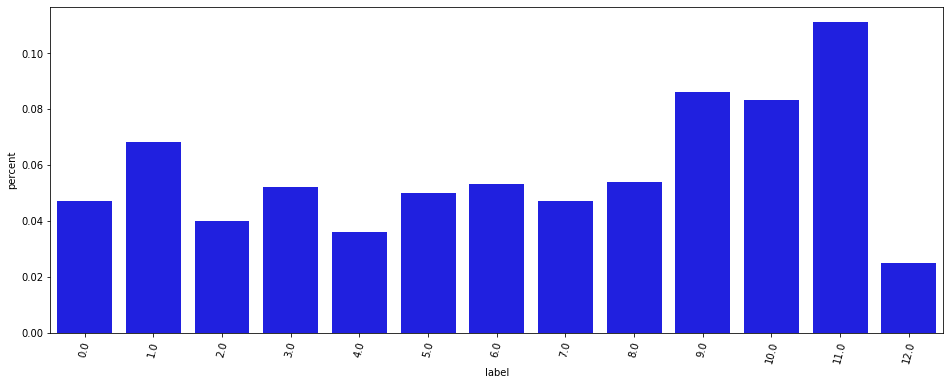

In [188]:
data_raw = pd.read_csv("cap_one_reviews.csv") 

combined = pd.concat([doc_topic_pairs_df, data_raw], axis=1)
combined = combined.sort_values(by="best_probability", ascending = False)
combined.head()

a = pd.DataFrame(combined.best_topic.value_counts(sort=True))
a['percent'] = a['best_topic']/1000
a['label'] = a.index

# Barplot number of topics
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="label", y="percent", data=a, color="b")
plt.setp(ax.get_xticklabels(), rotation=75);

In [189]:
a

,best_topic,percent,label
11.0,111,0.111,11.0
9.0,86,0.086,9.0
10.0,83,0.083,10.0
1.0,68,0.068,1.0
8.0,54,0.054,8.0
6.0,53,0.053,6.0
3.0,52,0.052,3.0
5.0,50,0.050,5.0
7.0,47,0.047,7.0
0.0,47,0.047,0.0


In [190]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation,strip_numeric

lda_topics = lda_model.show_topics(num_words=15, num_topics=13)

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

for topic in lda_topics:
    print(topic)
    topics.append(preprocess_string(topic[1], filters))

print(topics)

(0, '0.123*"lots" + 0.062*"get" + 0.059*"technology" + 0.051*"new" + 0.049*"fun" + 0.039*"tech" + 0.035*"move" + 0.025*"high" + 0.022*"talent" + 0.021*"overall" + 0.019*"ceo" + 0.017*"better" + 0.016*"put" + 0.016*"average" + 0.015*"industry"')
(1, '0.053*"career" + 0.050*"development" + 0.048*"opportunity" + 0.048*"learn" + 0.048*"management" + 0.045*"growth" + 0.037*"many" + 0.036*"leadership" + 0.031*"amazing" + 0.027*"grow" + 0.023*"right" + 0.022*"strong" + 0.022*"experience" + 0.018*"new" + 0.016*"positive"')
(2, '0.443*"good" + 0.095*"pay" + 0.061*"people" + 0.038*"atmosphere" + 0.026*"talented" + 0.023*"cutting_edge" + 0.022*"relaxed" + 0.015*"exposure" + 0.012*"away" + 0.010*"okay" + 0.008*"technology" + 0.006*"boss" + 0.006*"imagine" + 0.004*"ambiance" + 0.004*"enterprise"')
(3, '0.123*"worklife" + 0.063*"campus" + 0.051*"competitive" + 0.047*"friendly" + 0.043*"amp" + 0.039*"compensation" + 0.038*"free" + 0.027*"food" + 0.027*"diverse" + 0.026*"around" + 0.023*"back" + 0.022

In [191]:
topic_num = 12

print(topics[topic_num])

['salary', 'training', 'decent', 'package', 'good', 'cool', 'holiday', 'severance', 'end', 'great', 'quick', 'push', 'surface', 'pay', 'account']


In [192]:
pd.set_option('display.max_colwidth', -1)
pro_groupings = pd.DataFrame(combined[combined['best_topic']==topic_num])
#pprint(pro_groupings['cons'])
pro_groupings.pros

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


164    Flexible schedule, benefits, onsite conveniences                                                                                                                                                                         
11     Wonderful benefits. Flexibility. Company tries to stay ahead of trends.                                                                                                                                                  
588    Benefits on par with others in industry. Nothing special                                                                                                                                                                 
219    Pay and benefits are very good                                                                                                                                                                                           
167    Never boring, plenty of stimulating work. Great benefits, fantastic PTO, excellent training a

# Negative Reviews

In [193]:
# Change this for whatever starting text you are using
text_to_use = con_final_processed_text

In [194]:
# tokenize sentences
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(text_to_use))

print(data_words[:1])

[['would', 'great', 'better', 'coffee', 'available']]


Text(0, 0.5, 'Frequency')

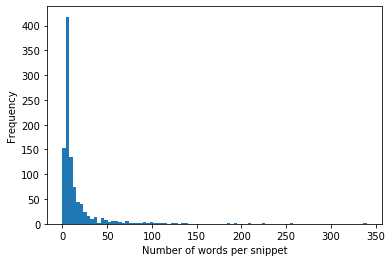

In [195]:
# Remove short reviews
# Create a list for clean snippets.
words_clean = [None] * len(data_words)
# Create a list of word counts for each clean snippet.
word_counts_per_snippet = [None] * len(data_words)

# Process words in all snippets.
for i in range(len(data_words)):
    words_clean[i] = [snippet.lower() for snippet in data_words[i]]
    word_counts_per_snippet[i] = len(words_clean[i])
    
    # Plot a histogram for word counts per snippet, set bins to num of unique values in the list.
plt.hist(word_counts_per_snippet, bins = len(set(word_counts_per_snippet))) 
plt.xlabel('Number of words per snippet')
plt.ylabel('Frequency')

In [196]:
# Convert word counts list and snippets list to numpy arrays.
word_counts_array = np.array(word_counts_per_snippet) 
clean_array = np.array(words_clean) 
print(len(clean_array))

1000


In [197]:
# Find indices of all snippets where there are greater than or equal to 4 words.
valid_snippets = np.where(word_counts_array >= 5)[0] 
print(len(valid_snippets))

704


In [198]:
# Subset the clean_array to keep only those where there are at least 4 words.
clean_array = clean_array[valid_snippets] 
print(len(clean_array))
# Convert the array back to a list.
clean_array = clean_array.tolist() 


704


In [199]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(clean_array, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[clean_array], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[clean_array[0]]])

['would', 'great', 'better', 'coffee', 'available']


In [200]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [201]:
# LEMMNITIZE
# Form Bigrams
data_words_bigrams = make_bigrams(clean_array)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[['great', 'well', 'coffee', 'available']]
[[(0, 1), (1, 1), (2, 1), (203, 1), (1311, 1)]]


[[('available', 1), ('coffee', 1), ('great', 1), ('better', 1), ('would', 1)]]

In [202]:
nlp = spacy.load("en_core_web_sm")

In [203]:
len(corpus)

704

In [204]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=22, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=10,
                                           alpha=1,
                                           per_word_topics=True)

In [205]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(10,
  '0.150*"many" + 0.057*"management" + 0.049*"bad" + '
  '0.041*"forced_distribution" + 0.038*"vision" + 0.037*"promotion" + '
  '0.035*"development" + 0.034*"top" + 0.031*"industry" + 0.030*"frequent"'),
 (3,
  '0.157*"much" + 0.149*"pay" + 0.087*"growth" + 0.067*"low" + 0.058*"room" + '
  '0.048*"middle" + 0.025*"lots" + 0.019*"financial" + 0.016*"line" + '
  '0.014*"management"'),
 (0,
  '0.190*"people" + 0.071*"know" + 0.059*"still" + 0.052*"good" + 0.046*"poor" '
  '+ 0.032*"constantly" + 0.030*"call" + 0.030*"company" + 0.028*"almost" + '
  '0.027*"customer"'),
 (11,
  '0.106*"business" + 0.063*"home" + 0.059*"branch" + 0.055*"forced" + '
  '0.054*"different" + 0.049*"corporate" + 0.039*"banking" + 0.025*"small" + '
  '0.024*"retail" + 0.020*"online"'),
 (9,
  '0.132*"lots" + 0.097*"high" + 0.068*"long" + 0.066*"favoritism" + '
  '0.061*"place" + 0.038*"support" + 0.038*"advancement" + 0.032*"hiring" + '
  '0.029*"limited" + 0.024*"management"'),
 (20,
  '0.081*"lack" + 0.0

In [206]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.828956212089821

Coherence Score:  0.44859899726518077


In [91]:
# Compute the coherance score for a range of topics to see which one performs best
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=10,
                                           alpha=1,
                                           #eta=.01,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary,
coherence='c_v') 
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [92]:
start = 2
limit = 40
step = 2

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=data_words_bigrams, limit=limit, start=start, step=step)

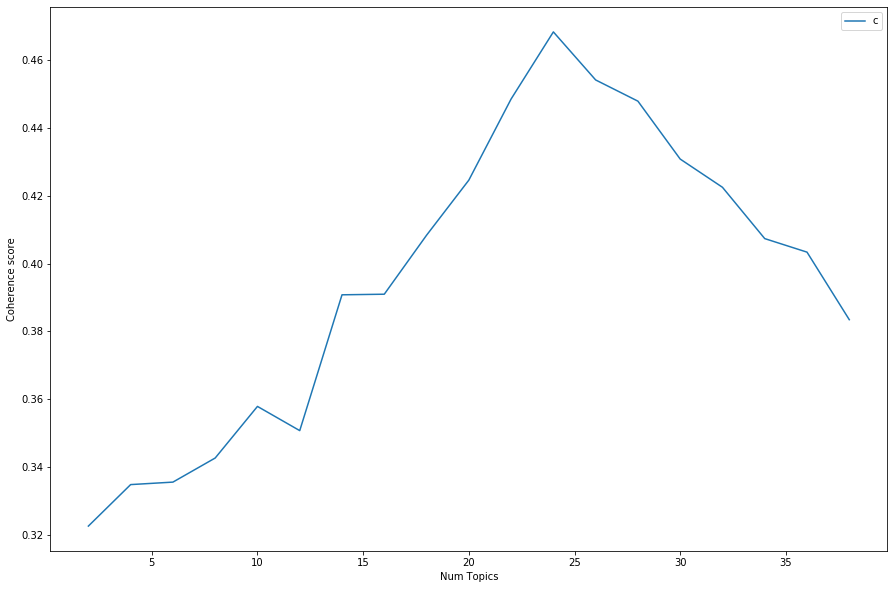

In [93]:
# Plot graph of topic list
# Show graph
import matplotlib.pyplot as plt 
limit=limit; start=start; step=step;
plt.figure(figsize=(15, 10))
x = range(start, limit, step)
plt.plot(x, coherence_values) 
plt.xlabel("Num Topics") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best') 
plt.savefig('con_coherence.png')
plt.show() 


In [94]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3225
Num Topics = 4  has Coherence Value of 0.3348
Num Topics = 6  has Coherence Value of 0.3355
Num Topics = 8  has Coherence Value of 0.3426
Num Topics = 10  has Coherence Value of 0.3578
Num Topics = 12  has Coherence Value of 0.3507
Num Topics = 14  has Coherence Value of 0.3908
Num Topics = 16  has Coherence Value of 0.391
Num Topics = 18  has Coherence Value of 0.4084
Num Topics = 20  has Coherence Value of 0.4246
Num Topics = 22  has Coherence Value of 0.4486
Num Topics = 24  has Coherence Value of 0.4684
Num Topics = 26  has Coherence Value of 0.4542
Num Topics = 28  has Coherence Value of 0.448
Num Topics = 30  has Coherence Value of 0.4309
Num Topics = 32  has Coherence Value of 0.4225
Num Topics = 34  has Coherence Value of 0.4074
Num Topics = 36  has Coherence Value of 0.4034
Num Topics = 38  has Coherence Value of 0.3834


In [149]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.190289 -0.245083  1       1        11.041329
8      0.062578 -0.102595  2       1        4.942513 
0      0.126360 -0.019445  3       1        4.870292 
14    -0.028137 -0.100493  4       1        4.809031 
17     0.036675  0.040703  5       1        4.798600 
13    -0.121811 -0.159647  6       1        4.678673 
19     0.007273  0.004993  7       1        4.590979 
15    -0.140947 -0.097143  8       1        4.435678 
18     0.106134  0.095332  9       1        4.422715 
7      0.128122  0.062177  10      1        4.334540 
1     -0.066986 -0.027895  11      1        4.266850 
10    -0.138291 -0.005555  12      1        4.117876 
11     0.022276  0.105792  13      1        4.070323 
5      0.104365  0.098363  14      1        4.056574 
20    -0.074378 -0.031820  15      1        4.007583 
12    -0.102791  0.031712  16      1        3.975392 
4      0.096651  0.004356  17      1        3.933478 
9     -0.137595  0.064691  18      1        3.843030 
6      0.025181  0.107438  19      1        3.836855 
3     -0.084995  0.085506  20      1        3.806355 
21    -0.022616  0.071180  21      1        3.628001 
16     0.012644  0.017433  22      1        3.533323 , topic_info=           Term        Freq       Total Category  logprob  loglift
17   work        200.000000  200.000000  Default  30.0000  30.0000
49   management  246.000000  246.000000  Default  29.0000  29.0000
177  people      147.000000  147.000000  Default  28.0000  28.0000
22   job         90.000000   90.000000   Default  27.0000  27.0000
40   company     149.000000  149.000000  Default  26.0000  26.0000
..       ...            ...         ...      ...      ...      ...
377  growth      0.319385    35.018909   Topic22 -6.9599  -1.3543 
166  little      0.134353    32.370960   Topic22 -7.8258  -2.1416 
688  really      0.072500    41.967613   Topic22 -8.4427  -3.0181 
17   work        0.080547    200.414322  Topic22 -8.3374  -4.4764 
98   get         0.076742    123.236519  Topic22 -8.3858  -4.0385 

[861 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
611   15     0.777406  able          
213   17     0.886928  absolutely    
1081  6      0.899168  accountability
499   4      0.635335  action        
1046  21     0.817234  actively      
...  ..           ...     ...        
1311  16     0.652891  would         
358   1      0.910010  wrong         
314   1      0.222169  year          
314   8      0.759076  year          
1122  15     0.686775  young         

[707 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 1, 15, 18, 14, 20, 16, 19, 8, 2, 11, 12, 6, 21, 13, 5, 10, 7, 4, 22, 17])

In [207]:
# Save the plot as a self-contained HTML file.
pyLDAvis.save_html(vis,"NEG_LDAvis.html")

# Inspect the negative reviews

In [208]:
# Create dataframe that takes hishest rated topic for each document
doc_num = 4
# Extract the vector of tf_idf weights for the document.
doc_vec = corpus[doc_num] 
print(doc_vec)

doc_topics = lda_model.get_document_topics(doc_vec) 
print(doc_topics)

[(32, 1), (34, 1), (35, 1), (37, 1)]
[(0, 0.04000088), (1, 0.04000088), (2, 0.040000875), (3, 0.04000088), (4, 0.04000088), (5, 0.04000088), (6, 0.04000088), (7, 0.0409885), (8, 0.079983145), (9, 0.04000088), (10, 0.0799997), (11, 0.04000088), (12, 0.04000088), (13, 0.04000088), (14, 0.079012744), (15, 0.040000964), (16, 0.04000088), (17, 0.04000088), (18, 0.04000088), (19, 0.04000088), (20, 0.04000088), (21, 0.04000088)]


In [209]:
# Initialize maximum probability score.
max_prob = 0
# Initialize best topic.
best_topic = 0
# Loop over all topics for the document. 
for topic in doc_topics:
    if max_prob <= topic[1]: #if current topic's probability is as high as max 
        max_prob = topic[1] # make current topic's probability the new max 
        best_topic = topic[0] #<­ make current topic best
# Create a tuple with information we just dot.
doc_topic_pair = (doc_num, best_topic, max_prob) 
print(doc_topic_pair)

(4, 10, 0.0799997)


In [210]:
def GetDocTopicPair(doc_num, corpus, lda_model):
    # Extract the vector of tf_idf weights for the document.
    doc_vec = corpus[doc_num]
    # Extract topic probabilities for that document.
    doc_topics = lda_model.get_document_topics(doc_vec) 
    max_prob = 0
    best_topic = 0
    for topic in doc_topics:
        if max_prob <= topic[1]: 
            max_prob = topic[1] 
            best_topic = topic[0]
    doc_topic_pair = (doc_num, best_topic, max_prob) 
    return(doc_topic_pair)

In [211]:
len(corpus)

704

In [212]:
# Create an empty list of the same length as the number of documents.
doc_topic_pairs = [None]*id2word.num_docs 
# Loop through a range of document indices. 
for i in range(id2word.num_docs):
# For each document index, get the document­topic tuple.
    doc_topic_pairs[i] = GetDocTopicPair(i, corpus, lda_model) 
    print(doc_topic_pairs[100])

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.0800

(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)
(100, 16, 0.08000049)


In [213]:
# Make a dataframe out of a list of tuples.
doc_topic_pairs_df = pd.DataFrame(doc_topic_pairs)
# Assign column names to the dataframe.
doc_topic_pairs_df.columns = ["doc_id", "best_topic", "best_probability"] 
print(doc_topic_pairs_df.head(25))

    doc_id  best_topic  best_probability
0   0       12          0.108823        
1   1       13          0.131789        
2   2       4           0.078252        
3   3       13          0.094575        
4   4       10          0.080000        
5   5       5           0.111286        
6   6       13          0.120110        
7   7       10          0.160262        
8   8       19          0.083328        
9   9       9           0.142845        
10  10      16          0.093168        
11  11      2           0.141487        
12  12      0           0.217522        
13  13      19          0.085145        
14  14      7           0.194027        
15  15      15          0.078644        
16  16      16          0.149291        
17  17      8           0.074143        
18  18      14          0.112297        
19  19      19          0.080130        
20  20      13          0.099988        
21  21      8           0.169328        
22  22      13          0.164402        
23  23      7   

In [214]:
doc_topic_pairs_df.describe()
# The probability that any one document is assigned to only one topic is relatively low
# Highest single probability is 64% and at 75% percentile highest percentage is 28%

,doc_id,best_topic,best_probability
count,704.000000,704.000000,704.000000
mean,351.500000,9.765625,0.113626
std,203.371581,6.347716,0.048581
min,0.000000,0.000000,0.045455
25%,175.750000,4.000000,0.083076
50%,351.500000,9.000000,0.104301
75%,527.250000,15.000000,0.127511
max,703.000000,21.000000,0.784981


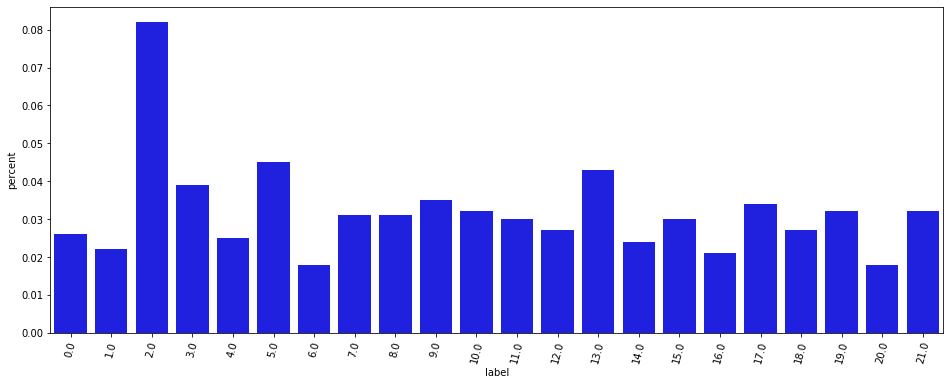

In [215]:
data_raw = pd.read_csv("cap_one_reviews.csv") 

combined = pd.concat([doc_topic_pairs_df, data_raw], axis=1)
combined = combined.sort_values(by="best_probability", ascending = False)
combined.head()

a = pd.DataFrame(combined.best_topic.value_counts(sort=True))
a['percent'] = a['best_topic']/1000
a['label'] = a.index

# Barplot number of topics
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="label", y="percent", data=a, color="b")
plt.setp(ax.get_xticklabels(), rotation=75);

In [219]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation,strip_numeric

lda_topics = lda_model.show_topics(num_words=15, num_topics=22)

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

for topic in lda_topics:
    print(topic)
    topics.append(preprocess_string(topic[1], filters))

print(topics)

(0, '0.190*"people" + 0.071*"know" + 0.059*"still" + 0.052*"good" + 0.046*"poor" + 0.032*"constantly" + 0.030*"call" + 0.030*"company" + 0.028*"almost" + 0.027*"customer" + 0.021*"stressful" + 0.021*"delivery" + 0.018*"auto" + 0.017*"ideas" + 0.017*"coaching"')
(1, '0.153*"like" + 0.119*"management" + 0.076*"also" + 0.061*"senior" + 0.057*"work" + 0.032*"talent" + 0.026*"people" + 0.022*"left" + 0.022*"ridiculous" + 0.018*"seem" + 0.018*"performance" + 0.016*"top" + 0.015*"deliver" + 0.014*"regular" + 0.012*"hiring"')
(2, '0.055*"manager" + 0.033*"get" + 0.026*"even" + 0.025*"end" + 0.025*"rating" + 0.020*"role" + 0.019*"back" + 0.019*"way" + 0.019*"capital" + 0.018*"toxic" + 0.015*"actual" + 0.014*"team" + 0.014*"stay" + 0.014*"find" + 0.013*"current"')
(3, '0.157*"much" + 0.149*"pay" + 0.087*"growth" + 0.067*"low" + 0.058*"room" + 0.048*"middle" + 0.025*"lots" + 0.019*"financial" + 0.016*"line" + 0.014*"management" + 0.013*"frequently" + 0.011*"mobility" + 0.008*"excessive" + 0.008*"

In [226]:
topic_num = 1

print(topics[topic_num])

['like', 'management', 'also', 'senior', 'work', 'talent', 'people', 'left', 'ridiculous', 'seem', 'performance', 'top', 'deliver', 'regular', 'hiring']


In [228]:
pd.set_option('display.max_colwidth', -1)
pro_groupings = pd.DataFrame(combined[combined['best_topic']==topic_num])
#pprint(pro_groupings['cons'])
pro_groupings

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,doc_id,best_topic,best_probability,date,employee_title,location,employee_status,review_title,years_at_company,helpful,pros,cons,advice_to_mgmt,rating_overall,rating_balance,rating_culture,rating_career,rating_comp,rating_mgmt
666,666.0,1.0,0.139298,Sat Mar 23 2019 08:38:18 GMT-0400 (Eastern Daylight Time),Principal Data Analyst,"McLean, VA",Former Employee,Great Balance and Career Progression,I worked at Capital One full-time for more than 3 years,1,"This is a great place to start your career since, at the early levels, they have defined criteria with which you can progress your career quickly. It's an incredibly understanding and flexible place as well - many employees work from home when they need to. They were very understanding of my needs when I moved to New York and allowed me to continue working from there. I still have nothing but love for Capital One.","Some of the Data Analyst roles are ~100% BAU work, but I feel that every job needs at least 20% of innovative or interesting work for self-growth. I'm very fortunate that my role allowed me to do that.",NaN,5.0,5.0,5.0,5.0,5.0,3.0
488,488.0,1.0,0.130914,Tue Jun 18 2019 05:20:21 GMT-0400 (Eastern Daylight Time),Senior Software Engineer,"McLean, VA",Current Employee,Great!!,I have been working at Capital One full-time for more than 5 years,0,Good company to learn and gain great experience. Lots of opportunities to explore latest in tech. A tech company ant just a bank,Does not do a good job of keeping their employee's morale high,NaN,5.0,5.0,4.0,4.0,4.0,3.0
378,378.0,1.0,0.130433,Thu Aug 15 2019 08:27:10 GMT-0400 (Eastern Daylight Time),Universal Branch Associate,"Long Beach, NY",Former Employee,Decent place to work,I worked at Capital One full-time for more than a year,0,Great people and fair compensation,Hard to advance without playing politics,NaN,4.0,4.0,3.0,3.0,4.0,2.0
181,181.0,1.0,0.130107,Fri Nov 29 2019 19:47:45 GMT-0500 (Eastern Standard Time),Senior Manager,NaN,Current Employee,Senior Manager,I have been working at Capital One full-time,1,"Challenging, Benefits AWS Food Learning Opportunity Lots of learning from smart people.","Politics Performance Management Back Stabbing Calibration, Slow in immigration",NaN,3.0,2.0,2.0,3.0,5.0,2.0
126,126.0,1.0,0.127198,Thu Dec 05 2019 13:58:57 GMT-0500 (Eastern Standard Time),Scrum Master,"McLean, VA",Current Employee,They think they’re amazing.,I have been working at Capital One full-time for more than 8 years,5,"Decent benefits, the people are just good people in spite of the performance management pressure.","Performance management is loathed by all. There is a forced distribution known as rank and yank. 20% of all teams must be at the bottom. Which if leaders are recruiting and developing top talent, it’s becomes a ridiculous exercise in drawing a short straw to determine who’s going to get “it” this year.",NaN,4.0,3.0,1.0,1.0,4.0,1.0
345,345.0,1.0,0.126182,Wed Aug 28 2019 07:07:17 GMT-0400 (Eastern Daylight Time),Invoice Management,"Plano, TX",Former Employee,"Great culture, benefits, and company",I worked at Capital One full-time for more than 5 years,0,"The facility and amenities are impressive, the benefits are great! depending on the role there is a great work life balance",The salary is fairly competitive.,NaN,4.0,5.0,5.0,4.0,5.0,3.0
664,664.0,1.0,0.120426,Wed Mar 20 2019 05:33:08 GMT-0400 (Eastern Daylight Time),Principal Risk Specialist,"Plano, TX",Current Employee,best place to work,I have been working at Capital One full-time for more than 5 years,2,"Great culture, benefits and beautiful campus",Promotion process can be based on how many people/managers like you.,NaN,5.0,5.0,5.0,5.0,5.0,4.0
674,674.0,1.0,0.118744,Sun Mar 03 2019 07:09:24 GMT-0500 (Eastern Standard Time),Associate,"Chicago, IL",Current Employee,77 W. Wacker,I have been working at Capital One full-time for more than 3 years,7,"Decent wages, Awesome benefits love the culture and flexible work from home days depending on your manager. Our office